In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.constants import M_sun, G, mu0
import astropy.units as u
from scipy.interpolate import griddata, LinearNDInterpolator, interpn
import tqdm


sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist
sys.path.append('../my_python_utilities')


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [2]:
data = pipeline(snap = 710, run = 'my_core_13restart')
print(data.time)
data.recalc_L(verbose = 1); 

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1261.76it/s]


21211.7281094472
Converged mean angular momentum vector after 0 iteration(s)


In [3]:
height = 10; radius = 100
height /= data.au_length; radius /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_cartcoor = []
patch_values = []
for p in tqdm.tqdm(data.sn.patches):
    idx = np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height) | (abs(p.cyl_z / p.cyl_R) < 0.3)))
    patch_cartcoor.extend(p.cyl_r[1:, idx[0], idx[1], idx[2]].T.tolist())
    patch_values.extend(p.var('d')[idx[0], idx[1], idx[2]].tolist())
patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)
print('Number of cells included in the dataset',np.shape(patch_cartcoor))

100%|██████████| 4165/4165 [00:01<00:00, 2560.28it/s]


Number of cells included in the dataset (927354, 2)


In [4]:
height = 10; radius = 100
height /= data.au_length; radius /= data.au_length
patch_l = np.asarray([p.level for p in data.sn.patches if (p.cyl_R < radius).any() & ((abs(p.cyl_z) < height).any() | (abs(p.cyl_z / p.cyl_R) < 0.3).any())]).squeeze() 
pp = np.asarray([p for p in data.sn.patches if (p.cyl_R < radius).any() & ((abs(p.cyl_z) < height).any() | (abs(p.cyl_z / p.cyl_R) < 0.3).any())]).squeeze()

In [5]:
sort_idx = np.asarray(np.flip(np.argsort(patch_l)), dtype=int).squeeze()

# Rules for exluding or including patches:
### - Exclude patches that have 8 nbors with level + 1 i.e. exlude parent patches covered by children
### - Include all cells in patches that have 0 nbors with level+1 -- they are complete unconvered, i.e. include child patches on high level!
### - For the remaining patches: <br>   for each level+1 nbor: exclude (or give zero weight) to cells that are inside

In [6]:
height = 10; radius = 100
height /= data.au_length; radius /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_cartcoor = []
patch_values = []
ipatch=0
for p in tqdm.tqdm(data.sn.patches):      
    ipatch += 1
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1] 
    # The next line is making sure the children are only the refined children within the parent patch.
    # We want the leafs containd in a sphere which is 1/4 * |diag|
    leafs = len([n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12])           
    print("Level={} Len={} C={} Leafs={}".format(p.level,len(nbors),len(children),leafs))
    if ipatch==10: break

  0%|          | 9/4165 [00:00<00:02, 1587.55it/s]

Level=4 Len=8 C=8 Leafs=8
Level=5 Len=72 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8
Level=6 Len=98 C=64 Leafs=8


In [7]:
height = 5; radius = 5
height /= data.au_length; radius /= data.au_length
# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_cartcoor = []
patch_values = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue
    idx = np.asarray(np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height) | (abs(p.cyl_z / p.cyl_R) < 0.3))))
    for lp in leafs: 

        extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_idx = np.asarray(np.nonzero((p.xyz[0] > extent[0,0]) & (p.xyz[0] < extent[0,1])
                                 & (p.xyz[1] > extent[1,0]) & (p.xyz[1] < extent[1,1])
                                 & (p.xyz[2] > extent[2,0]) & (p.xyz[2] < extent[2,1])))
        to_remove_from_idx = np.all(idx.T[:, None, :] == covered_idx.T, axis = -1).any(axis = 1)
        idx = np.copy(idx.T[~to_remove_from_idx].T)
        if np.sum(idx) == 0:
            continue
    #if np.sum(idx) != 0: break
    if np.sum(idx) == 0:
            continue    


    new_coor = p.rel_xyz[:, idx[0], idx[1], idx[2]].T # This bug was here - I used p.cyl_r
    new_value = p.var('d')[idx[0], idx[1], idx[2]].T
    patch_cartcoor.extend(new_coor.tolist())
    patch_values.extend(new_value.tolist())

patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)
print('Number of cells included in the dataset',np.shape(patch_cartcoor))

100%|██████████| 4165/4165 [00:00<00:00, 6706.37it/s]

Number of cells included in the dataset (1615, 3)


In [9]:
patch_cartcoor

array([[-7.15782352e-06, -3.33734048e-06, -1.42911672e-06],
       [-7.15782352e-06, -3.33734048e-06, -4.75442408e-07],
       [-7.15782352e-06, -3.33734048e-06,  4.78231908e-07],
       ...,
       [ 7.14729123e-06,  3.33837973e-06, -4.75442408e-07],
       [ 7.14729123e-06,  3.33837973e-06,  4.78231908e-07],
       [ 7.14729123e-06,  3.33837973e-06,  1.43190622e-06]])

In [8]:
N = len(patch_cartcoor)
distances = []

count = 0
for i in tqdm.tqdm(range(N)):
    for j in range(i, N):
        if (patch_cartcoor[i] == patch_cartcoor[j]).all(): 
            count += 1
            continue
        distances.append(dist(patch_cartcoor[i]* data.au_length, patch_cartcoor[j]* data.au_length))
        if dist(patch_cartcoor[i]* data.au_length, patch_cartcoor[j]* data.au_length) == 0:
            print('Hammer time')
            break
distances = np.asarray(distances)           
count

100%|██████████| 1615/1615 [00:25<00:00, 62.16it/s] 


1615

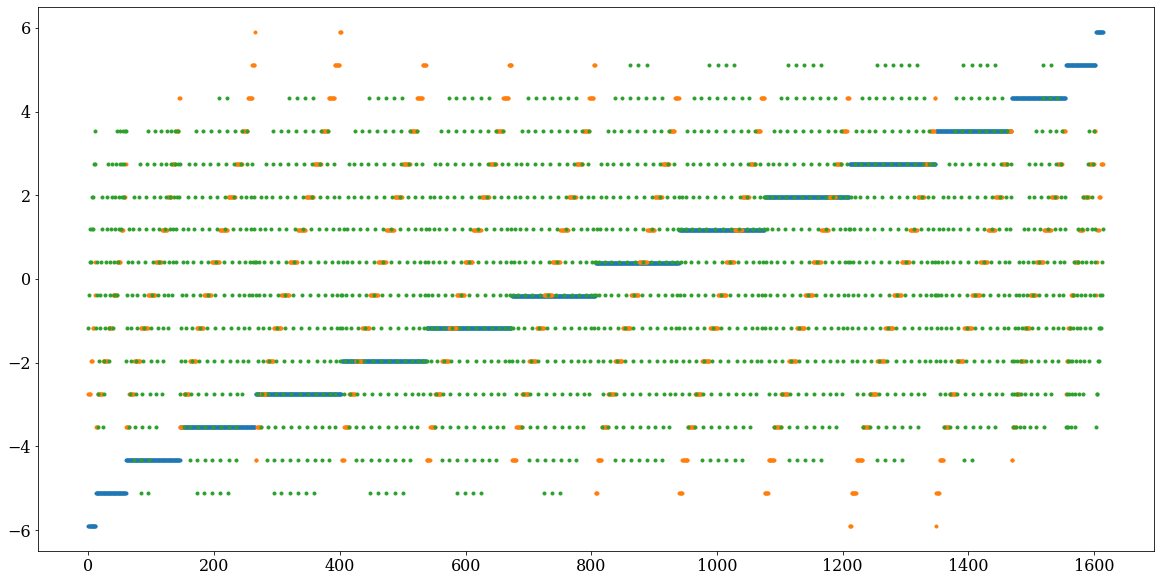

In [9]:
plt.figure(figsize = (20,10))
plt.plot(patch_cartcoor * data.au_length, '.')

In [10]:
np.count_nonzero(distances), len(distances), (~np.isnan(patch_cartcoor)).all()

(1303305, 1303305, True)

In [11]:
for p in data.sn.patches:
    if p.level == 20:
        break
p.ds * data.au_length

array([0.78690881, 0.78690881, 0.78690881])

([<matplotlib.lines.Line2D at 0x7f0ddcda3ca0>], 0.7869088076015203)

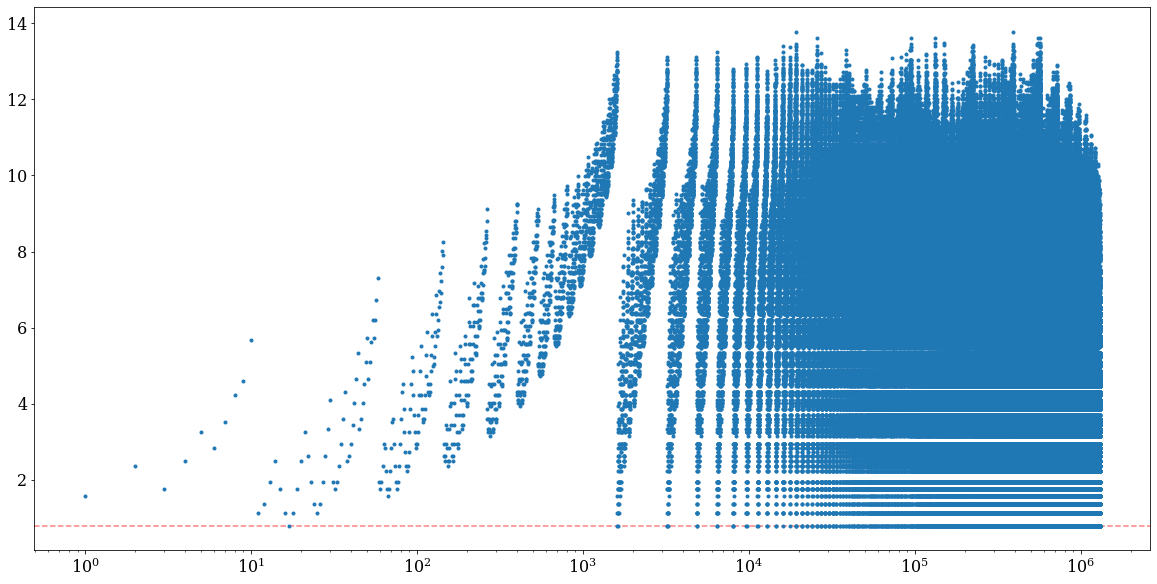

In [12]:
plt.figure(figsize =(20,10) )
plt.axhline(0.78690881, ls = '--', alpha = 0.5, c='red')
plt.semilogx(distances,'.'), np.min(distances)

## pilot_2D.ipynb without exluding parent partches includes ~900k cells where exluding them only has 800k.

# min distance 1e-16 au to griddata

In [13]:
p.ds * data.au_length, p.level

(array([0.78690881, 0.78690881, 0.78690881]), 20)

In [14]:
box_length = 10 # [au]
box_height = 10
Nr = 100
Nh = 40
bins = np.linspace(-box_length//2, box_length//2, Nr) 
h_bins = np.linspace(-box_height//2, box_height//2, Nh) 
xx, yy, zz = np.meshgrid(bins, bins, h_bins, indexing = 'ij')

In [15]:
interpol = griddata(patch_cartcoor * data.au_length, patch_values, xi = (zz, xx, yy), method='linear') #Takes ~20s

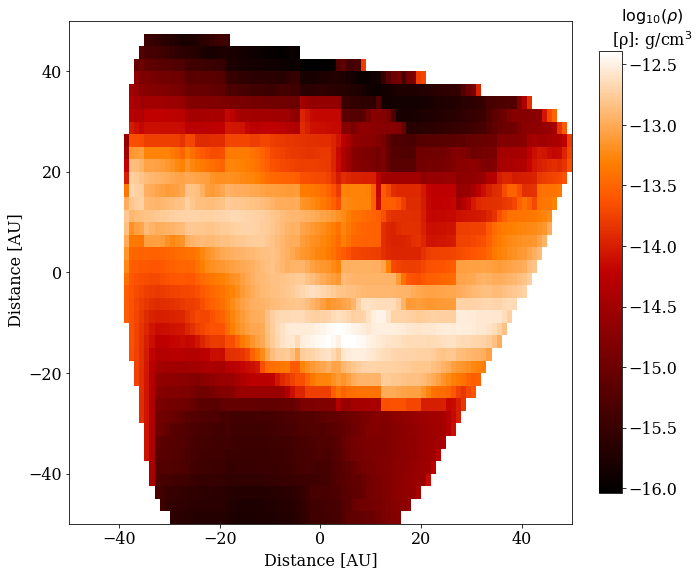

In [16]:
fig, axs = plt.subplots(figsize = (10,10))

cs = plt.imshow(np.log10(interpol[Nh//2,...] * data.cgs_density).T, extent=(-50, 50,-50, 50), cmap = 'gist_heat', origin='lower')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.04);
cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -25, y = 1.1, rotation = 0, fontsize = 16)
axs.set_xlabel(f'Distance [AU]', fontsize = 16); axs.set_ylabel(' Distance [AU]', fontsize = 16)
plt.tight_layout()

In [17]:
height = 10; radius = 45
height /= data.au_length; radius /= data.au_length
# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_cartcoor = []
patch_values = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue
    idx = np.asarray(np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height) | (abs(p.cyl_z / p.cyl_R) < 0.3))))
    for lp in leafs: 

        extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_idx = np.asarray(np.nonzero((p.xyz[0] > extent[0,0]) & (p.xyz[0] < extent[0,1])
                                 & (p.xyz[1] > extent[1,0]) & (p.xyz[1] < extent[1,1])
                                 & (p.xyz[2] > extent[2,0]) & (p.xyz[2] < extent[2,1])))
        to_remove_from_idx = np.all(idx.T[:, None, :] == covered_idx.T, axis = -1).any(axis = 1)
        idx = np.copy(idx.T[~to_remove_from_idx].T)
        if np.sum(idx) == 0:
            continue
    if np.sum(idx) == 0:
            continue    


    new_coor = p.rel_xyz[:, idx[0], idx[1], idx[2]].T # This bug was here - I used p.cyl_r
    new_value = p.var('d')[idx[0], idx[1], idx[2]].T
    patch_cartcoor.extend(new_coor.tolist())
    patch_values.extend(new_value.tolist())

patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)
print('Number of cells included in the dataset',np.shape(patch_cartcoor))

  0%|          | 0/4165 [00:00<?, ?it/s]

100%|██████████| 4165/4165 [00:00<00:00, 4280.26it/s]


Number of cells included in the dataset (234454, 3)


In [18]:
box_length = 50 # [au]
box_height = 10
Nr = 100
Nh = 40
bins = np.linspace(-box_length//2, box_length//2, Nr) 
h_bins = np.linspace(-box_height//2, box_height//2, Nh) 
xx, yy, zz = np.meshgrid(bins, bins, h_bins, indexing = 'ij')

In [19]:
interpol = griddata(patch_cartcoor * data.au_length, patch_values, xi = (zz, xx, yy), method='linear')